In [1]:
#Importing libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import os
import shutil
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


In [2]:
CONFIGURATION = {
    'MODEL_NAME': 'ViT',
    'ZOOM': 100, # 40 / 100 / 200  400  -> Number of images: 1995 + 2081 + 2013 + 1820
    'DATA_SPLIT': 'custom', # original / custom
    'N_EPOCHS': 200,
    'BATCH_SIZE': 256,
    'IMAGE_SIZE': 224,
    'PATCH_SIZE': 16,
    'LR': 0.001,
    'WEIGHT_DECAY': 0.0001,
    'DROP_OUT': 0.7,
    'SPT': False, # Shifted Patch Tokenization 
}

## Load data

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler

#Loading the csv file
df = pd.read_csv("datasets\BreakHis\Folds.csv")
dataset = df.iloc[:7909, :]
dataset = dataset[dataset['mag'] == CONFIGURATION['ZOOM']]
dataset = dataset.rename(columns = {"filename":"path"})

#Creating new columns for the filename, file location and labels from the path column
dataset['filename'] = dataset['path'].apply(lambda x:x.split("/")[-1])
dataset["label"] = dataset['path'].apply(lambda x: x.split("/")[3])
dataset["sublabel"] = dataset['path'].apply(lambda x: x.split("/")[5])
dataset['file_loc'] = dataset['label'] + "_" + dataset['filename']

#Encoding the class to integer
dataset['class'] = dataset['label'].apply(lambda x: 0 if x =='benign' else 1)

if (CONFIGURATION['DATA_SPLIT'] == 'original'):
    print("Original Split")
    train_val_df = dataset[dataset['grp'] == 'train']
    test_df = dataset[dataset['grp'] == 'test']
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1)
    for train_index, validation_index in sss.split(train_val_df['path'], train_val_df['class']):
        train_df, val_df = train_val_df.iloc[train_index], train_val_df.iloc[validation_index]

    print("train_df shape: {}".format(train_df.shape))
    print("val_df shape: {}".format(val_df.shape))
    print("test_df shape: {}".format(test_df.shape))
    
elif (CONFIGURATION['DATA_SPLIT'] == 'custom'):
    print("Custom split")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
    for train_index, validation_index in sss.split(dataset['path'], dataset['class']):
        train_df, val_test_df = dataset.iloc[train_index], dataset.iloc[validation_index]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.67, random_state=1)
    for train_index, validation_index in sss.split(val_test_df['path'], val_test_df['class']):
        val_df, test_df = val_test_df.iloc[train_index], val_test_df.iloc[validation_index]
    
    print("train_df shape: {}".format(train_df.shape))
    print("val_df shape: {}".format(val_df.shape))
    print("test_df shape: {}".format(test_df.shape))
        
def balance_attributes(target_df, attribute = 'class'):
  X = target_df.drop(attribute, axis=1)
  y = target_df[attribute]
  ros = RandomOverSampler(random_state=42)
  X_resampled, y_resampled = ros.fit_resample(X, y)
  balanced_labels_df = pd.concat([X_resampled, y_resampled], axis=1)

  return balanced_labels_df

train_df = balance_attributes(train_df)

def load_data(dataframe):
    data_images = []
    data_labels = []
    
    for index, row in dataframe.iterrows():
        # Extract filename and class
        filename = "/kaggle/input/breakhis/BreaKHis_v1/" + row['path']
        image_class = row['class']

        img = cv2.imread(filename, cv2.IMREAD_COLOR)        
        img = cv2.resize(img, (CONFIGURATION['IMAGE_SIZE'], CONFIGURATION['IMAGE_SIZE']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            data_images.append(img)
            data_labels.append([image_class])
    return np.array(data_images, dtype="float"),  np.array(data_labels)

training_images, training_labels = load_data(train_df)
val_images, val_labels = load_data(val_df)
test_images, test_labels = load_data(test_df)

Custom split
train_df shape: (1456, 9)
val_df shape: (206, 9)
test_df shape: (419, 9)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [4]:
# !pip install gdown

In [5]:
# !gdown https://drive.google.com/uc?id=1PA7PM9L-Qk_5aqEiVrSbnumkOCv8Qe75

In [6]:
# !gdown https://drive.google.com/uc?id=1o-w-ndpTrnTIFXWFcnXiAS7hsJsrp-jM

In [7]:
# !gdown https://drive.google.com/uc?id=1SF3LBpHqrfH0R9_R93t9Ph2j3elexSup

In [8]:
# import pickle

# with open("/kaggle/working/training_images_reduced.pkl", 'rb') as f:
#     training_images_reduced = pickle.load(f)
    
# with open("/kaggle/working/val_images_reduced.pkl", 'rb') as f:
#     val_images_reduced = pickle.load(f)
    
# with open("/kaggle/working/test_images_reduced.pkl", 'rb') as f:
#     test_images_reduced = pickle.load(f)

The shape of dataset images: (2010, 224, 224, 3)
The shape of dataset labels: (2010, 1)
The first image of dataset:


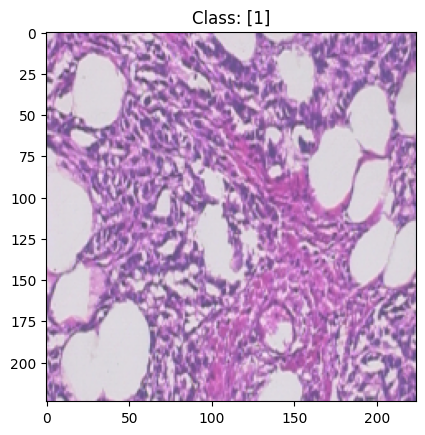

The shape of dataset images: (206, 224, 224, 3)
The shape of dataset labels: (206, 1)
The first image of dataset:


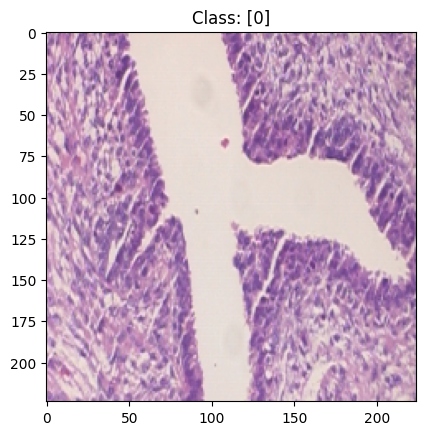

The shape of dataset images: (419, 224, 224, 3)
The shape of dataset labels: (419, 1)
The first image of dataset:


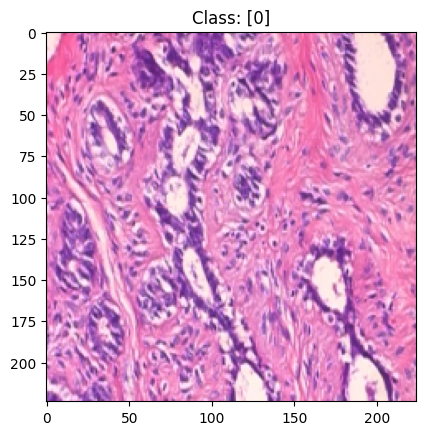

In [9]:
def check_data(images, labels):
    #The shape of the datasets
    print("The shape of dataset images:", images.shape)
    print("The shape of dataset labels:", labels.shape)
    print("The first image of dataset:")
    plt.title("Class: " + str(labels[0]))
    plt.imshow(images[0] / 255)
    plt.show()

check_data(training_images, training_labels)
check_data(val_images, val_labels)
check_data(test_images, test_labels)

## Model training

In [10]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import keras_cv

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

NUM_CLASSES = 2
INPUT_SHAPE = (CONFIGURATION['IMAGE_SIZE'], CONFIGURATION['IMAGE_SIZE'], 3)

# DATA
BATCH_SIZE = CONFIGURATION['BATCH_SIZE']

# AUGMENTATION
IMAGE_SIZE = CONFIGURATION['IMAGE_SIZE']
PATCH_SIZE = CONFIGURATION['PATCH_SIZE']
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = CONFIGURATION['LR']
WEIGHT_DECAY = CONFIGURATION['WEIGHT_DECAY']

# TRAINING
EPOCHS = CONFIGURATION['N_EPOCHS']

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 4
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [512, 128]


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(training_images)

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla: # if SPT = True
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla: # if SPT = True
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches
    
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores
    
def mlp(x, hidden_units, dropout_rate, l2_rate=0.1):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu, 
                         kernel_regularizer=regularizers.l2(l2_rate))(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        if not vanilla: # if SPT = True
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
            
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(CONFIGURATION['DROP_OUT'])(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=CONFIGURATION['DROP_OUT'])
    
    outputs = layers.Dense(NUM_CLASSES)(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

checkpoint = ModelCheckpoint(f"/kaggle/working/{CONFIGURATION['MODEL_NAME']}.keras", save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                          patience=15,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=15,
                              verbose=1,
                              )

csv_logger = CSVLogger(f"/kaggle/working/{CONFIGURATION['MODEL_NAME']}_model.log")


callbacks = [checkpoint, early_stopping, csv_logger]

In [13]:
def get_optimizer():
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      CONFIGURATION['LR'],
      decay_steps=20*50,
      decay_rate=1,
      staircase=False
    )
    optimizer =  tf.keras.optimizers.Adam(lr_schedule)
    return optimizer

def get_metrics():
    return [keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

def get_loss():
    return keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [23]:
def run_experiment(model):
    
    model.compile(
        optimizer=get_optimizer(),
        loss=get_loss(),
        metrics=get_metrics(),
    )
    
    model.summary()
    
    history = model.fit(
        training_images, training_labels,
        validation_data=(val_images, val_labels), 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callbacks,
        verbose = 1
    )

    return model, history


# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=not CONFIGURATION['SPT'])
model, history = run_experiment(vit)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:359: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          7 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shifted_patch_toke… │ [(None, 196, 64), │     49,216 │ data_augmentatio… │
│ (ShiftedPatchToken… │ (None, 14, 14,    │            │                   │
│                     │ 768)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 196, 64)   │     12,544 │ shifted_patch_to… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 196, 128)  │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 196, 64)   │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 196, 64)   │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 196, 64)   │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 6,883,657 (26.26 MB)

 Trainable params: 6,883,650 (26.26 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/200
1/8 ━━━━━━━━━━━━━━━━━━━━ 5:30 47s/step - accuracy: 0.5625 - loss: 190.5206

W0000 00:00:1710575165.523388     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6230 - loss: 182.7147   

W0000 00:00:1710575202.787211     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.6263 - loss: 181.8720 - val_accuracy: 0.7767 - val_loss: 154.7440
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6685 - loss: 147.9870 - val_accuracy: 0.7913 - val_loss: 123.6755
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7117 - loss: 117.3990 - val_accuracy: 0.7621 - val_loss: 96.7590
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.7357 - loss: 91.4040 - val_accuracy: 0.8107 - val_loss: 74.9030
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.7395 - loss: 70.6853 - val_accuracy: 0.8204 - val_loss: 58.2251
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7659 - loss: 55.1070 - val_accuracy: 0.8155 - val_loss: 45.9741
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7775 - loss: 43.6794 - val_accuracy: 0.8155 - val_loss: 37.0677
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8256 - loss: 35.3297 - val_accuracy: 0.81

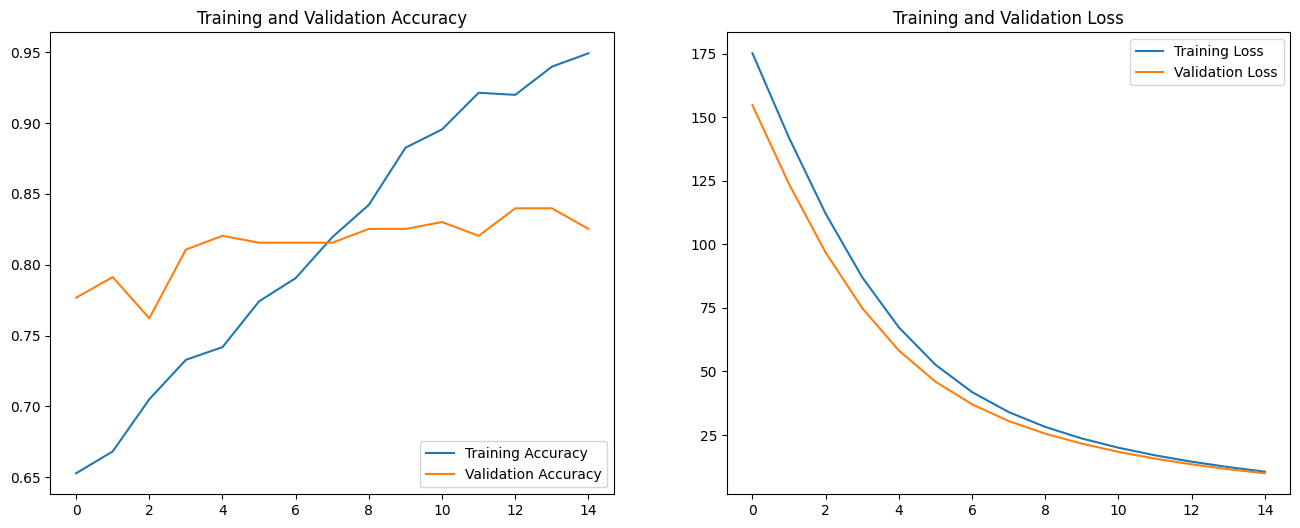

In [24]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
loss, accuracy= model.evaluate(val_images, val_labels)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.7501 - loss: 154.8082
Val loss: 154.71
Val accuracy: 77.67%


In [26]:
loss, accuracy= model.evaluate(test_images, test_labels)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.7917 - loss: 154.8174
Test loss: 154.8
Test accuracy: 80.19%


W0000 00:00:1710575270.735483     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
y_pred = model.predict(test_images)

rounded_test_labels = test_labels.flatten()
rounded_predictions =  np.argmax(y_pred, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step


W0000 00:00:1710575282.387894     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [28]:
#Classification report
print(classification_report(rounded_test_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       129
           1       0.84      0.88      0.86       290

    accuracy                           0.80       419
   macro avg       0.77      0.76      0.76       419
weighted avg       0.80      0.80      0.80       419



In [29]:
#Accuracy
accuracy = accuracy_score(rounded_test_labels, rounded_predictions)
print('Accuracy: %f' % accuracy)
#Precision
precision = precision_score(rounded_test_labels, rounded_predictions)
print('Precision: %f' % precision)
# Recall
recall = recall_score(rounded_test_labels, rounded_predictions, pos_label=1)
print('Recall: %f' % recall)
#Specificity 
specificity = recall_score(rounded_test_labels, rounded_predictions, pos_label=0)
print('Specificity: %f' % specificity)
#F1-score
F1_score = f1_score(rounded_test_labels, rounded_predictions)
print('F1_score: %f' % F1_score)

Accuracy: 0.801909
Precision: 0.843854
Recall: 0.875862
Specificity: 0.635659
F1_score: 0.859560


[[ 82  47]
 [ 36 254]]


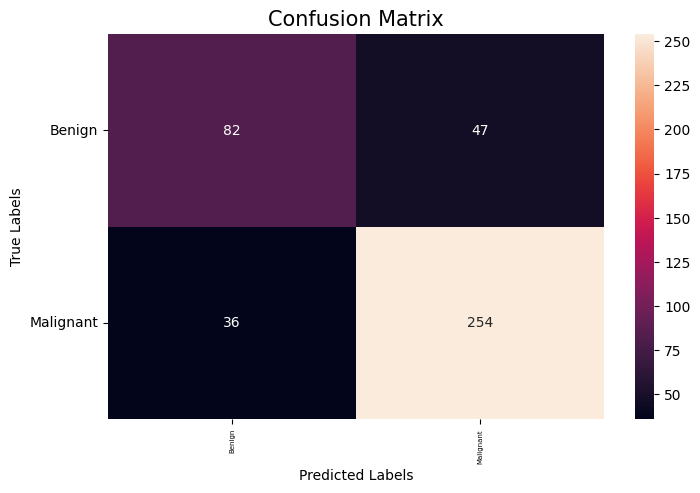

In [30]:
#Confusion matrix
cm = confusion_matrix(rounded_test_labels, rounded_predictions)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

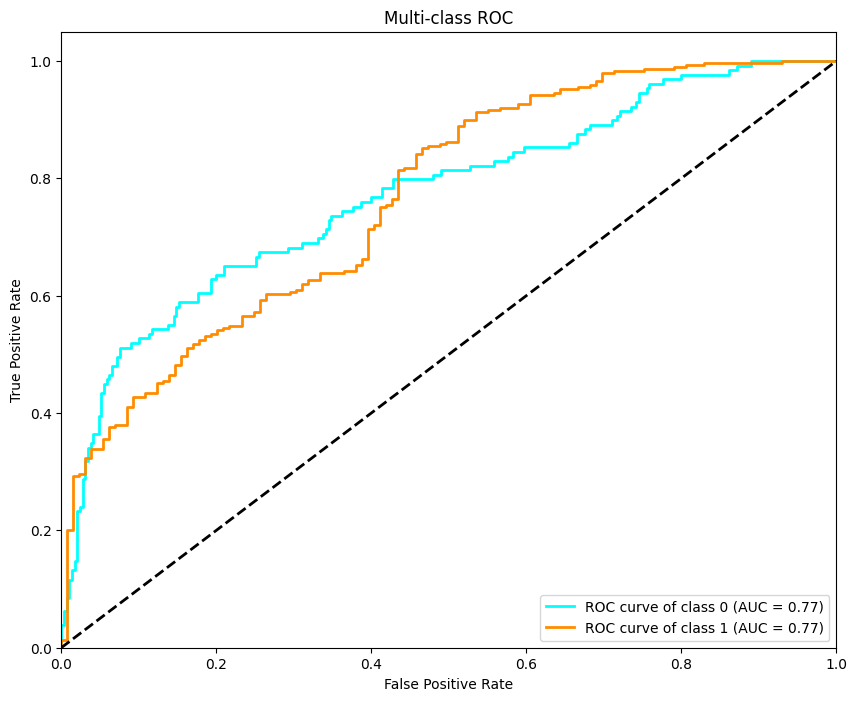

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

n_classes = test_labels.max() + 1  # Assuming labels are from 0 to n_classes-1

# Convert labels to one hot encoding for multi-class ROC curve
y_test_one_hot = np.eye(n_classes)[test_labels.flatten()]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()